# Experiments with LogRegression

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd
from tqdm import tqdm

In [2]:
def to_seconds(time):
    return time.microseconds * 1e-6 + time.seconds

def f(w, X, y):
    res = 0
    for i in range(X.shape[0]):
        res += np.log(1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def grad_f(w, X, y):
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

In [3]:
class Model:
    def __init__(self, d):
        self.d = d
        self.w = np.zeros(d)

        self.converge = []

        self.write_time = False
        self.times = []
        self.operations = []
        self.operations_done = 0
        self.label = ""

        self.D_ts = []
    
    def reset(self):
        self.w = np.zeros(self.d)
        self.converge = []
        self.times = []
        self.D_ts = []
        self.operations = []
        self.operations_done = 0

    def AdamL2(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8]):
        self.reset()
        self.label = "AdamL2"

        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        if self.write_time:
            self.time_start = dt.now()

        for i in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
            grad = grad + weight_decay * self.w
        
            self.converge.append(np.linalg.norm(grad))

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps)

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

    def AdamW(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0, special_convergence=False, params=[0.9, 0.999, 1e-8]):
        self.reset()
        self.label = "AdamW"
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)

        if self.write_time:
            self.time_start = dt.now()

        for i in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            v_bias_corr = v / (1 - beta2 ** (i + 1))
            self.w = self.w - learning_rate * m_bias_corr / (np.sqrt(v_bias_corr) + eps)
            self.w = self.w - weight_decay * learning_rate * self.w
            
            if special_convergence:
                self.converge.append(np.linalg.norm(grad) +  self.w * weight_decay / (np.sqrt(v_bias_corr) + eps))
            else:
                self.converge.append(np.linalg.norm(grad))

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

            self.operations.append(self.operations_done)
            self.operations_done += self.d
    
    def AdamWBA(self, X, y, steps=200, batch_adaption_size=10, batch_type="random", learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8], variance_reduction=False):
        self.reset()
        self.label = "AdamW: type " + batch_type + f", size={batch_adaption_size}" + (" VR" if variance_reduction else "")
        
        assert len(params) == 3
        beta1, beta2, eps = params
        m = np.zeros(self.d)
        v = np.zeros(self.d)
        v_bias_corr = np.zeros(self.d)
        Dt_summ = np.zeros(self.d)

        if self.write_time:
            self.time_start = dt.now()

        for i in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
        
            self.converge.append(np.linalg.norm(grad))

            adaption_indexes = []
            if i == 0:
                adaption_indexes = range(self.d)
            elif batch_type == "random":
                adaption_indexes = np.random.choice(self.d, size=(batch_adaption_size,), replace=False)
            # elif batch_type == "max":
            #     adaption_indexes = np.argsort(v_bias_corr)[-batch_adaption_size:]
            # elif batch_type == "mean":
            #     adaption_indexes = np.argsort(v_bias_corr)[(self.d  - batch_adaption_size) // 2: (self.d + batch_adaption_size) // 2]

            m = beta1 * m + (1 - beta1) * grad
            m_bias_corr = m / (1 - beta1 ** (i + 1))
            if variance_reduction:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))

                Dt_summ += (np.sqrt(v_bias_corr) + eps)
                Dt = Dt_summ / (i + 1)
            else:
                v[adaption_indexes] = (beta2 * v + (1 - beta2) * (grad * grad))[adaption_indexes]
                v_bias_corr[adaption_indexes] = v[adaption_indexes] / (1 - beta2 ** (i + 1))
                Dt = (np.sqrt(v_bias_corr) + eps)

            self.w = self.w - learning_rate * m_bias_corr / Dt
            self.w = self.w - weight_decay * learning_rate * self.w

            self.D_ts.append(np.sqrt(v_bias_corr) + eps)

            self.operations.append(self.operations_done)
            self.operations_done += batch_adaption_size
    
    def AdamLIKE(self, X, y, steps=200, typ="SEGA", batch_adaption_size=10, learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8]):
        pass

    def GD(self, X, y, steps=200, learning_rate=1e-3, weight_decay=0):
        self.reset()
        self.label = "GD"

        if self.write_time:
            self.time_start = dt.now()

        for _ in tqdm(range(steps)):
            if self.write_time:
                self.times.append(to_seconds(dt.now() - self.time_start))
            
            grad = grad_f(self.w, X, y)
            grad = grad + weight_decay * self.w

            self.w = self.w - learning_rate * grad
            self.converge.append(np.linalg.norm(grad))

    def get_converge_iteration(self):
        x_plot = range(len(self.converge))
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_converge_operations(self):
        x_plot = self.operations
        y_plot = self.converge
        return x_plot, y_plot
    
    def get_D_t(self):
        return self.D_ts

## Mushrooms

In [4]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = y * 2 - 3
n, d = X.shape
print("n = {}, d = {}".format(n, d))

n = 8124, d = 112


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
from sklearn import preprocessing

In [6]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_train)

## Batch adaption

### обновление по батчам

100%|██████████| 200/200 [00:08<00:00, 23.44it/s]


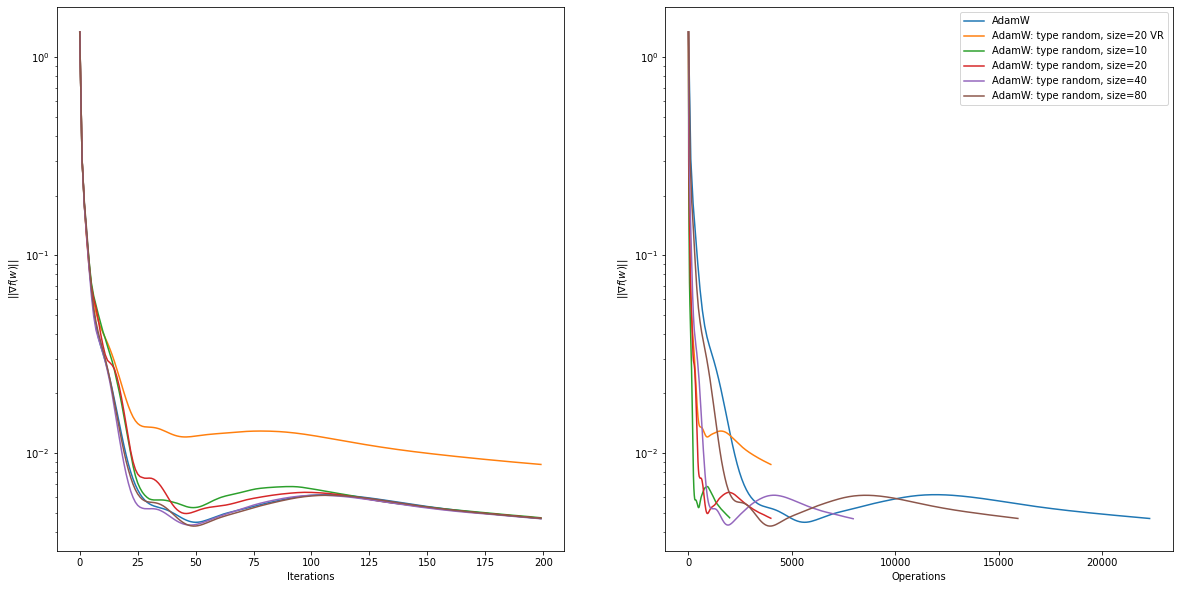

In [7]:
M = Model(d)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_xlabel("Iterations")
ax[0].set_ylabel('$||\\nabla f(w)||$')
ax[1].set_xlabel("Operations")
ax[1].set_ylabel('$||\\nabla f(w)||$')

M.AdamW(X, y, weight_decay=0.1, learning_rate=0.1)
x_plot, y_plot = M.get_converge_iteration()
ax[0].semilogy(x_plot, y_plot, label=M.label)
x_plot, y_plot = M.get_converge_operations()
ax[1].semilogy(x_plot, y_plot, label=M.label)

M.AdamWBA(X, y, weight_decay=0.1, learning_rate=0.1, batch_type='random', batch_adaption_size=20, variance_reduction=True)
x_plot, y_plot = M.get_converge_iteration()
ax[0].semilogy(x_plot, y_plot, label=M.label)
x_plot, y_plot = M.get_converge_operations()
ax[1].semilogy(x_plot, y_plot, label=M.label)

for type in ['random']:
    for batch_adaption_size in [10, 20, 40, 80]:
        M.AdamWBA(X, y, weight_decay=0.1, learning_rate=0.1, batch_type=type, batch_adaption_size=batch_adaption_size)
        x_plot, y_plot = M.get_converge_iteration()
        ax[0].semilogy(x_plot, y_plot, label=M.label)
        x_plot, y_plot = M.get_converge_operations()
        ax[1].semilogy(x_plot, y_plot, label=M.label)


ax[1].set_xlabel("Operations")
ax[1].set_ylabel('$||\\nabla f(w)||$')

plt.legend()
# plt.savefig("/fig1.jpg")

### Различные сочетания

In [35]:
def AdamVARIOUS(self, X, y, steps=200, type_grad="full", type_precond="full", batch_adaption_size=10, bias_corr=False,
                learning_rate=1e-3, weight_decay=0, params=[0.9, 0.999, 1e-8]):
    self.reset()
    self.label = f"Adam:" + f", size={batch_adaption_size}, grad:{type_grad} precond:{type_precond}"
    
    assert len(params) == 3
    beta1, beta2, eps = params
    Dt, Dt_memory, Dt_memory_corrected = np.zeros(self.d), np.zeros(self.d), np.zeros(self.d)
    g, g_memory, g_memory_corrected = np.zeros(self.d), np.zeros(self.d), np.zeros(self.d)
    h = np.zeros(self.d)

    if self.write_time:
        self.time_start = dt.now()

    for i in tqdm(range(steps)):
        if self.write_time:
            self.times.append(to_seconds(dt.now() - self.time_start))
        
        grad = grad_f(self.w, X, y)
    
        self.converge.append(np.linalg.norm(grad))

        ids = np.random.choice(self.d, size=(batch_adaption_size,), replace=False)
        if i == 0:
            ids = range(self.d)

        if type_grad == "full":
            g_memory = beta1 * g_memory + (1 - beta1) * grad
            if bias_corr:
                g_memory_corrected = g_memory / (1 - beta1 ** (i + 1))
            else:
                g_memory_corrected = g_memory
            g = g_memory_corrected
        if type_grad == "batch":
            g_memory[ids] = beta1 * g_memory[ids] + (1 - beta1) * grad[ids]
            if bias_corr:
                g_memory_corrected[ids] = g_memory[ids] / (1 - beta1 ** (i + 1))
            else:
                g_memory_corrected[ids] = g_memory[ids]
            g = g_memory_corrected
        if type_grad == "SEGA":
            g_memory[ids] = h[ids] + self.d * (grad[ids] - h[ids])
            h[ids] = g_memory[ids]
            g = g_memory
        if type_grad == "SEGAd1":
            g_memory[ids] = grad[ids]
            if bias_corr:
                g_memory_corrected[ids] = g_memory[ids] / (1 - beta1 ** (i + 1))
            else:
                g_memory_corrected[ids] = g_memory[ids]
            g = g_memory_corrected
            
        if type_grad == "coord":
            g = np.zeros(d)
            g[ids] = grad[ids]

        if type_precond == "full":
            Dt_memory = beta2 * Dt_memory + (1 - beta2) * (grad * grad)
            if bias_corr:
                Dt_memory_corrected = Dt_memory / (1 - beta2 ** (i + 1))
            else:
                Dt_memory_corrected = Dt_memory
            Dt = np.sqrt(Dt_memory_corrected) + eps
        if type_precond == "batch":
            Dt_memory[ids] = beta2 * Dt_memory[ids] + (1 - beta2) * (grad * grad)[ids]
            if bias_corr:
                Dt_memory_corrected[ids] = Dt_memory[ids] / (1 - beta2 ** (i + 1))
            else:
                Dt_memory_corrected[ids] = Dt_memory[ids]
            Dt = np.sqrt(Dt_memory_corrected) + eps
        if type_precond == "g":
            Dt_memory = beta2 * Dt_memory + (1 - beta2) * (g * g)
            if bias_corr:
                Dt_memory_corrected = Dt_memory / (1 - beta2 ** (i + 1))
            else:
                Dt_memory_corrected = Dt_memory
            Dt = np.sqrt(Dt_memory_corrected) + eps
        if type_precond == "coord":
            Dt[ids] = (grad * grad)[ids]
            if bias_corr:
                Dt_memory_corrected[ids] = Dt[ids] / (1 - beta2 ** (i + 1))
            else:
                Dt_memory_corrected[ids] = Dt[ids]
            Dt[ids] = np.sqrt(Dt_memory_corrected)[ids] + eps
        if type_precond == "none":
            Dt = np.ones(self.d)
        

        self.w = self.w - learning_rate * g / Dt
        self.w = self.w - weight_decay * learning_rate * self.w

        
        self.operations.append(self.operations_done)
        self.operations_done += batch_adaption_size

Model.AdamVARIOUS = AdamVARIOUS

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 23.45it/s]


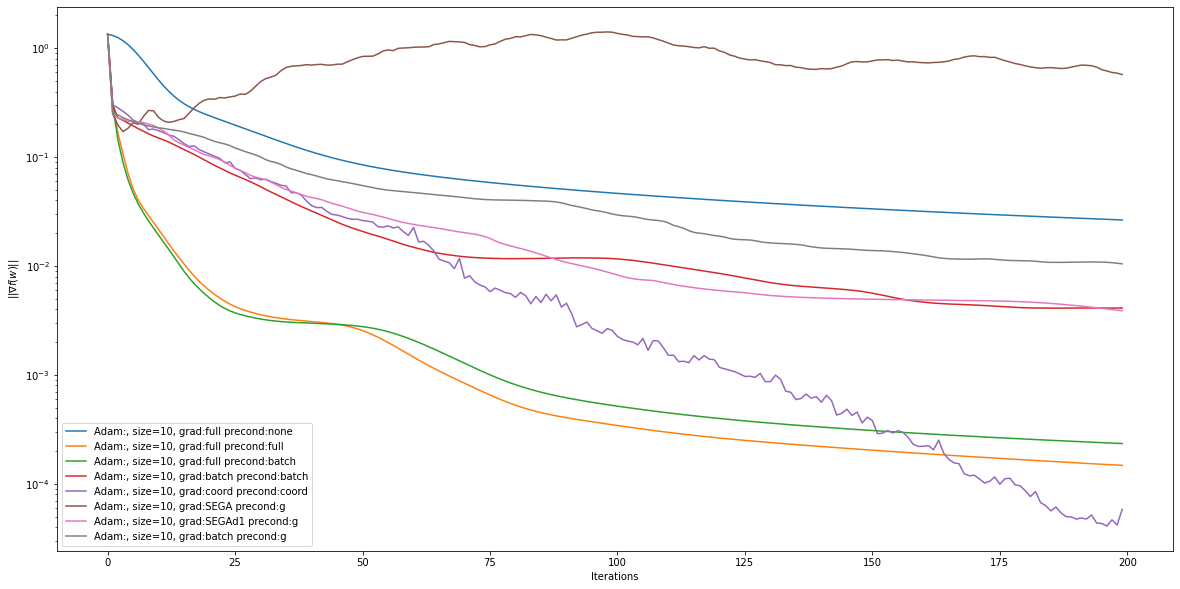

In [36]:
M = Model(d)

fig = plt.figure(figsize=(20, 10))

plt.xlabel("Iterations")
plt.ylabel('$||\\nabla f(w)||$')

# g  : 'full', 'full', 'full',  'batch', 'coord', 'SEGA', 'SEGAd1', 'batch'
# Dt : 'none', 'full', 'batch', 'batch',  'coord,  'g',    'g',      'g'
for type_grad, type_precond in zip(['full', 'full', 'full', 'batch', 'coord', 'SEGA', 'SEGAd1', 'batch'], 
                                   ['none', 'full', 'batch', 'batch', 'coord', 'g', 'g', 'g']):
    for batch_adaption_size in [10]:
        M.AdamVARIOUS(X, y, weight_decay=0, learning_rate=0.1, params=(0.9, 0.99, 1e-8),
                      type_grad=type_grad, type_precond=type_precond, batch_adaption_size=batch_adaption_size)
        x_plot, y_plot = M.get_converge_iteration()
        plt.semilogy(x_plot, y_plot, label=M.label)

plt.legend()
# plt.savefig("/fig1.jpg")

## Adaptive matrix $D_t$ investigation

In [ ]:
M.AdamW(X, y, weight_decay=0.1, learning_rate=0.1)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)
D_ts = M.get_D_t()

M.GD(X, y)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)

M.AdamL2(X, y, weight_decay=0.1, learning_rate=0.1)
x_plot, y_plot = M.get_converge_iteration()
plt.semilogy(x_plot, y_plot, label=M.label)

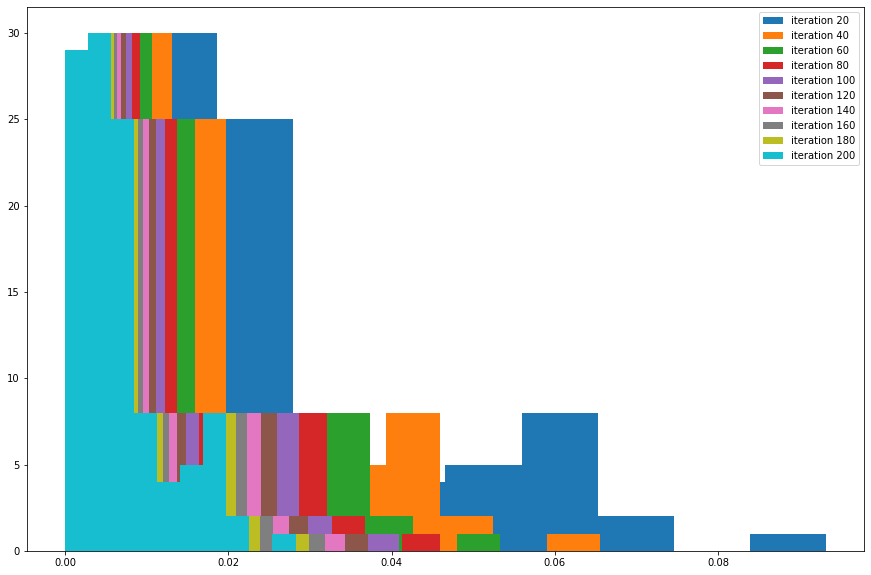

In [85]:
fig = plt.figure(figsize=(15, 10))
for i in range(19, 200, 20):
    plt.hist(D_ts[i], label=f"iteration {i + 1}")
plt.legend()